In [60]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from porter2stemmer import Porter2Stemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log,sqrt
import pandas as pd
import numpy as np
%matplotlib inline

In [61]:
mails = pd.read_csv('spam.csv', encoding = 'latin-1')
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [62]:
#Dropping redundant columns
mails.drop(mails.columns[2],axis = 1,inplace = True)
mails.drop(mails.columns[3],axis = 1,inplace = True)
mails.drop(mails.columns[2],axis = 1,inplace = True)

#Renaming columns
mails.rename(columns = {'v1':'label','v2':'message'})
mails.columns = ['label','message']

#Mapping 'ham' to 0 and 'spam' to 1
mails['label'].replace({"ham":0,"spam":1},inplace=True)
mails.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [63]:
trainIndex,testIndex = list(),list()
for i in range(mails.shape[0]):
    if np.random.uniform(0,1) < 0.75:
        trainIndex+= [i]
    else:
        testIndex+= [i]
trainData = mails.loc[trainIndex]
testData = mails.loc[testIndex]

#Resetting indices because the indices of the original df are appended to this list
trainData.reset_index(inplace = True)
trainData.drop(trainData.columns[0],axis = 1,inplace = True)
trainData.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


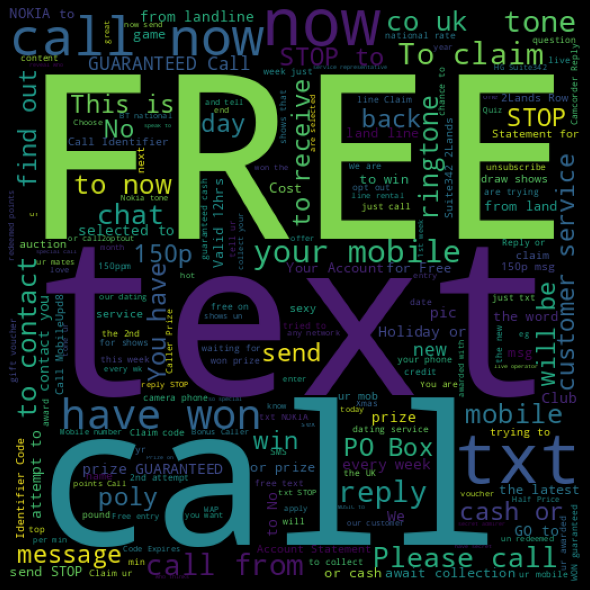

In [64]:
spam_words = ''.join(list(mails[mails['label'] == 1]['message']))
spam_wc = WordCloud(width = 512, height = 512).generate(spam_words)
plt.figure(figsize=(10,8),facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

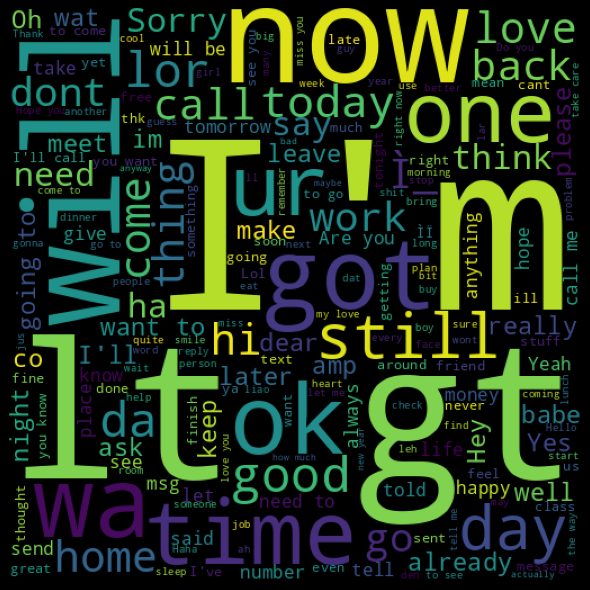

In [65]:
spam_words = ''.join(list(mails[mails['label'] == 0]['message']))	#Create a list of words where the label = 1(spam)
spam_wc = WordCloud(width = 512, height = 512).generate(spam_words)
plt.figure(figsize=(10,8),facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [66]:
def process_msg(message, stem = True, stop_words = True, l_case = True):
    
    #Making everything lowercase
    if l_case:
        message = message.lower()
        
    #Tokenizing the message into singular words and removing all the spaces
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    
    #Remove all the stop words
    if stop_words:
        sw = stopwords.words('english')
        words = [w for w in words if w not in sw]
    #Using port2stemmer to carry out stemming
    if stem:
        stemmer = Porter2Stemmer()
        words = [stemmer.stem(word) for word in words]
    return words

In [67]:
class SpamMessages(object):
    
    #Default constructor, initialises the messages(ham + spam) and labels for further use in local variables
    def __init__(self, trainData, method = 'tf-idf'):
        self.method = method
        self.mails,self.labels = trainData['message'],trainData['label']
    
    #Training function, first calls calculation of TF and IDF separately and then TF-IDF or Bag Of Words
    def train(self):
        self.TF_and_IDF()  #Calculation of TF and IDF separately
        if self.method == 'tf-idf':
            self.TF_IDF()  #Calulatio of TF-IDF(Default)
        else:
            self.BOW()     #Calculation via Bag Of Words
    
    def TF_and_IDF(self):
        totalMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(totalMessages):
            proc_message = process_msg(self.mails[i]) #Preprocess each message
            count = list()
            for word in proc_message:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word,0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word,0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word,0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word,0) + 1
        self.prob_spam_mails, self.prob_ham_mails = self.spam_mails / self.total, self.ham_mails / self.total
#             print("\nSpam words: ", self.spam_words)
#             print("Keys: ",len(list(self.tf_spam.keys())))

    def TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tfidf_spam = 0
        self.sum_tfidf_ham = 0
        total = self.spam_mails + self.ham_mails
        
        for word in self.tf_spam: #Finding TF(w/spam)*IDF(w/spam)
            self.prob_spam[word] = (self.tf_spam[word]) * log((total)/(self.idf_spam[word] + self.idf_ham.get(word,0)))
            self.sum_tfidf_spam += self.prob_spam[word]
        
        for word in self.tf_ham:  #Finding TF(w/ham)*IDF(w/ham)
            self.prob_ham[word] = (self.tf_ham[word]) * log((total)/(self.idf_ham[word] + self.idf_spam.get(word,0)))
            self.sum_tfidf_ham += self.prob_ham[word]
        
        for word in self.tf_spam: #P(w/spam) with Laplace smoothing(alpha = 1)
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tfidf_spam + len(list(self.prob_spam.keys())))
        
        for word in self.tf_ham: #P(w/ham) with Laplace smoothing(alpha = 1)
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tfidf_ham + len(list(self.prob_ham.keys())))
    
    def BOW(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + len(list(self.tf_spam.keys())))
        
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + len(list(self.tf_ham.keys())))
        
        self.prob_spam_mails, self.prob_ham_mails = self.spam_mails / self.total, self.ham_mails / self.total 
        
    def classify(self, proc_msg):
        spam,ham = 0,0
        for word in proc_msg:
            
            if word in self.prob_spam:
                spam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    spam -= log(self.sum_tfidf_spam + len(list(self.prob_spam.keys())))
                else:
                    spam -= leg(self.spam_words + len(list(self.prob_spam.keys())))
            
            if word in self.prob_ham:
                ham += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    ham -= log(self.sum_tfidf_ham + len(list(self.prob_ham.keys())))
                else:
                    ham -= log(self.ham_words + len(list(self.prob_ham.keys())))
            
            spam += log(self.prob_spam_mails)
            ham += log(self.prob_ham_mails)
#             print("\nspam = ",spam)
#             print("ham = ",ham)
            return spam >= ham
        
    def predict(self, testData):
        result = dict()
        for (i, msg) in enumerate(testData):
            proc_msg = process_msg(msg)
            if self.classify(proc_msg):
                result[i] = 1
            else:
                result[i] = 0
        return result

In [68]:
def metrics(labels, predictions):
    t_pos, t_neg, f_pos, f_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        t_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        t_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        f_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        f_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = t_pos / (t_pos + f_pos)
    recall = t_pos / (t_pos + f_neg)
    fscore = (2 * precision * recall)/ (precision + recall)
    accuracy = (t_pos + t_neg) / (t_pos + t_neg + f_pos + f_neg)
    print("Precision: ", precision)
    print("\nRecall: ", recall)
    print("\nF-Score: ", fscore)
    print("\nAccuracy: ",accuracy)

In [69]:
sc = SpamMessages(trainData,'tf-idf')
sc.train()
preds = sc.predict(testData['message'])
metrics(testData['label'], preds)

Precision:  0.7894736842105263

Recall:  0.45454545454545453

F-Score:  0.5769230769230769

Accuracy:  0.9222065063649222


In [70]:
pm = process_msg("Free weekly tournament to win money")
sc.classify(pm)

True